In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 0. IMPORTING DATA

In [357]:
def get_series(TICKER):
    '''
    input : a ticker 
    output : pandas series with adjusted close and dates as index
    NB : the csv extract from which we read the data go from 1/1/2012 to 12/31/2017
    '''    
    path = "/Users/edouardcuny/Desktop/quant/Carmela/data/" + TICKER
    df = pd.read_csv(path, index_col='Date', dtype={'Adj Close': np.float64}, na_values='null')
    df = df['Adj Close']
    df = df.rename(TICKER)
    return df

In [361]:
def print_info_stock(df):
    '''
    prints info on the series of the adjusted close of a stock
    visual way to check if everything seems fine
    '''
    print 'nom      : ' + df.name
    print 'min date : ' + str(min(df.index))
    print 'max date : ' + str(max(df.index))
    print 'nb dates : ' + str(len(df))
    print 'null     : ' + str(sum(df.isnull()))

In [362]:
GLE = get_series("GLE.PA.csv")

In [363]:
print_info_stock(GLE)

nom      : GLE.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


In [325]:
GLE[GLE.isnull()]
GLE = GLE[GLE.notnull()] # some rows have no value for the adjusted close, we delete those rows

# 1. FEATURE ENGINEERING
obj = predict cumulative @ today + 5 five trading days

**FEATURES USED**
- out_to_in_BB: True if the spot price went from outside the Bollinger band to the inside of the Bollinger band
- spike : adjusted close/RM (RM = rolling mean over a window to define)
- pre_spike : adjusted close/RM of the previous trading day
- spike_derivative : difference between the two last features
- crossed_RM_up : yesterday spot was < RM today spot > RM
- crossed_RM_down : yesterday spot was > RM today spot < RM
- mom_1 : cumulative return past day
- mom_5 : cumulative return past 5 days
- mom_10 : cumulative return past 10 days

## 1.1 BOLLINGER BANDS

In [332]:
def df_bollinger_features(stock, window_size):
    '''
    input = series of a stock's adjusted close
    output = dataframe w/ columns:
        - in_BB 
        - pr_in_BB
        - out_to_in_BB
        - rolling_mean
        - spike
        - pr_spike
        - spike_derivative
        - crossed_RM_up
        - crossed_RM_down
    '''
    
    # BOLLINGER BANDS
    rolling_mean = stock.rolling(window=window_size).mean()
    rolling_std = stock.rolling(window=window_size).std()
    upper_bb = rolling_mean + 2*rolling_std
    lower_bb = rolling_mean - 2*rolling_std

    # plot of BOLLINGER BANDS
    ax = stock[:100].plot()
    rolling_mean[:100].plot(ax=ax)
    upper_bb[:100].plot(ax=ax, color='c')
    lower_bb[:100].plot(ax=ax, color='c')
    plt.show()

    # inside BB
    in_BB = (stock < upper_bb) & (stock > lower_bb)
    in_BB[:window_size] = np.NaN
    
    # previous inside BB
    pr_in_BB = in_BB.shift(1) 

    # outside to inside BB
    out_to_in_BB = (pr_in_BB == 0) & (in_BB == 1)
    out_to_in_BB[:window_size+1] = np.NaN
    
    
    # Adjusted Close / RM
    spike = stock/rolling_mean
    pr_spike = spike.shift(1)
    spike_derivative = spike - pr_spike
    crossed_RM_up = (pr_spike < 1) & (spike > 1)
    crossed_RM_down = (pr_spike > 1) & (spike < 1)
    crossed_RM_up[:window_size] = np.NaN
    crossed_RM_down[:window_size] = np.NaN
    
    # renaming columns
    stock = stock.rename('Adj_Close')
    in_BB = in_BB.rename('in_BB')
    pr_in_BB = pr_in_BB.rename('pr_in_BB')
    rolling_mean = rolling_mean.rename('rolling_mean')
    out_to_in_BB = out_to_in_BB.rename('out_to_in_BB')
    spike = spike.rename('spike')
    pr_spike = pr_spike.rename('pr_spike')
    spike_derivative = spike_derivative.rename('spike_derivative')
    crossed_RM_up = crossed_RM_up.rename('crossed_RM_up')
    crossed_RM_down = crossed_RM_down.rename('crossed_RM_down')
    
    
    stock_df = pd.concat([in_BB,pr_in_BB,out_to_in_BB,rolling_mean,spike,pr_spike,spike_derivative,crossed_RM_up,crossed_RM_down], axis=1)
    return stock_df

## 1.2 MOMENTUM

In [333]:
def df_momentum(stock):
    '''
    input = series of a stock's adjusted close
    output = dataframe w/ columns:
        - mom_1 
        - mom_5 
        - mom_10
    '''
    
    # compute momentums
    mom_1 = (stock/stock.shift(1)-1)*100
    mom_5 = (stock/stock.shift(5)-1)*100
    mom_10 = (stock/stock.shift(10)-1)*100

    # rename columns
    mom_1 = mom_1.rename('mom_1')
    mom_5 = mom_5.rename('mom_5')
    mom_10 = mom_10.rename('mom_10')
    
    return pd.concat([mom_1,mom_5,mom_10],axis=1)
    

## 1.3 Y
We want to predict the cumulative return 5 days from now.

In [334]:
def y(stock):
    '''
    input = series of a stock's adjusted close
    output = series of the cumulative return 5 days from now
    '''
    
    y = (stock.shift(-5)/stock-1)*100
    y = y.rename('y')
    return y

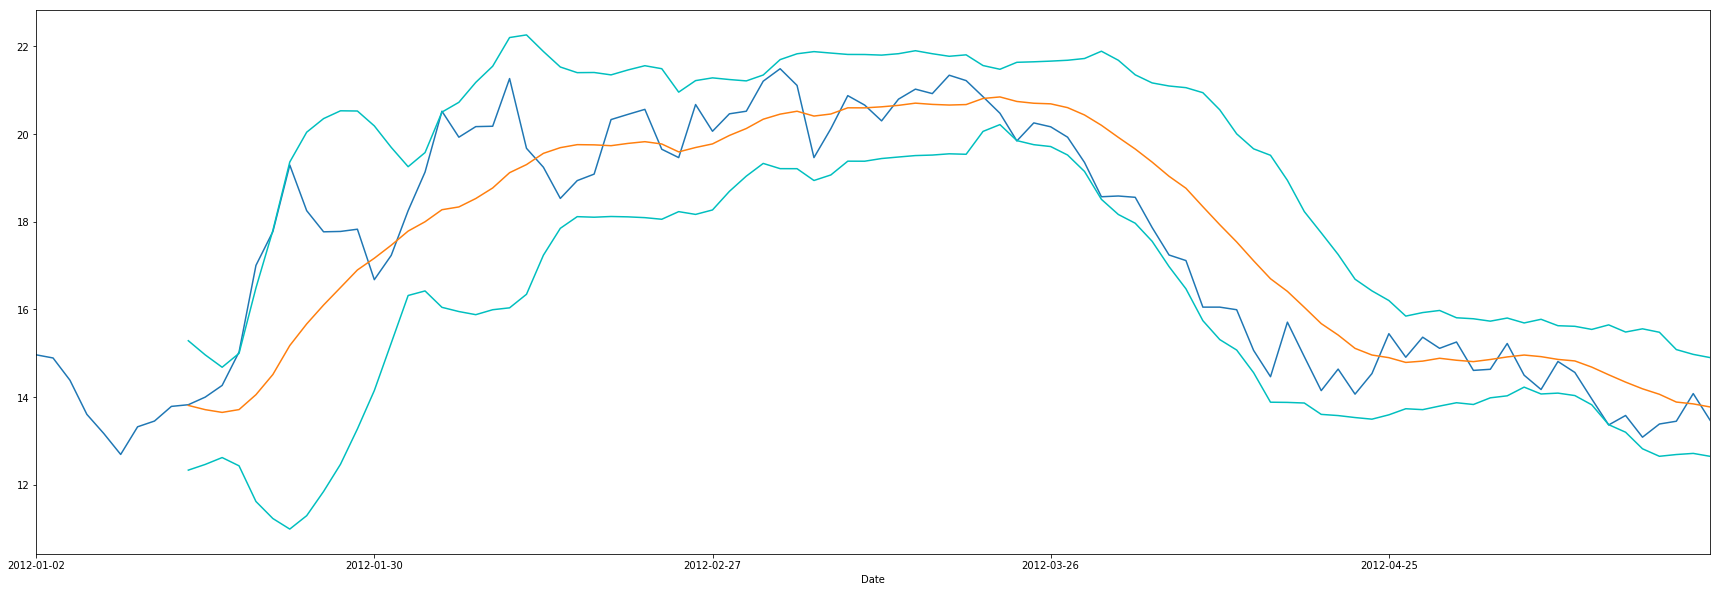

In [335]:
GLE_df = pd.concat([GLE,df_bollinger_features(GLE,10),df_momentum(GLE),y(GLE)], axis=1)

In [336]:
GLE_df.head(20)

,GLE.PA,in_BB,pr_in_BB,out_to_in_BB,rolling_mean,spike,pr_spike,spike_derivative,crossed_RM_up,crossed_RM_down,mom_1,mom_5,mom_10,y
Date,,,,,,,,,,,,,,
2012-01-02,14.964975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.182351
2012-01-03,14.893049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.480629,NaN,NaN,-10.539776
2012-01-04,14.385330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.409100,NaN,NaN,-6.470585
2012-01-05,13.606832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.411749,NaN,NaN,1.337064
2012-01-06,13.171040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.202744,NaN,NaN,4.979113
2012-01-09,12.692940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.629934,-15.182351,NaN,10.299994
2012-01-10,13.323355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.966659,-10.539776,NaN,7.081632
2012-01-11,13.454515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.984437,-6.470585,NaN,11.698118
2012-01-12,13.788764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.484289,1.337064,NaN,23.320023


# 2. ML

## 2.1 PREPARING THE DATA

In [311]:
df = GLE_df.copy()

# droping useless columns
df.drop([df.columns[0],'rolling_mean'],axis=1,inplace=True)

# removing rows w/ NaN i.e. first rows and last rows based on window_size
df.dropna(inplace=True)

# splitting X and Y
X = df.iloc[:,:-1]
Y = df.iloc[:,-1]

# features rescaling
from sklearn.preprocessing import scale
X.loc[:,'spike'] = scale(X['spike'])
X.loc[:,'pr_spike'] = scale(X['pr_spike'])
X.loc[:,'spike_derivative'] = scale(X['spike_derivative'])
X.loc[:,'mom_1'] = scale(X['mom_1'])
X.loc[:,'mom_5'] = scale(X['mom_5'])
X.loc[:,'mom_10'] = scale(X['mom_10'])

# train & test
split = 0.7 
n = int(0.7*df.shape[0])
X_train = X.iloc[:n,:]
X_test = X.iloc[n:,:]
Y_train = Y[:n]
Y_test = Y[n:]

'''
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape
'''

'\nprint X_train.shape\nprint X_test.shape\nprint Y_train.shape\nprint Y_test.shape\n'

## 2.2 RUNNING THE ALGORITHM

In [312]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
Y_pred = pd.Series(clf.predict(X_test))
Y_pred.index = Y_test.index
comparison = pd.concat([Y_pred,Y_test],axis=1)
comparison.columns = ['pred','real']

# 3. RESULTS

We plot a pred vs real vs random.

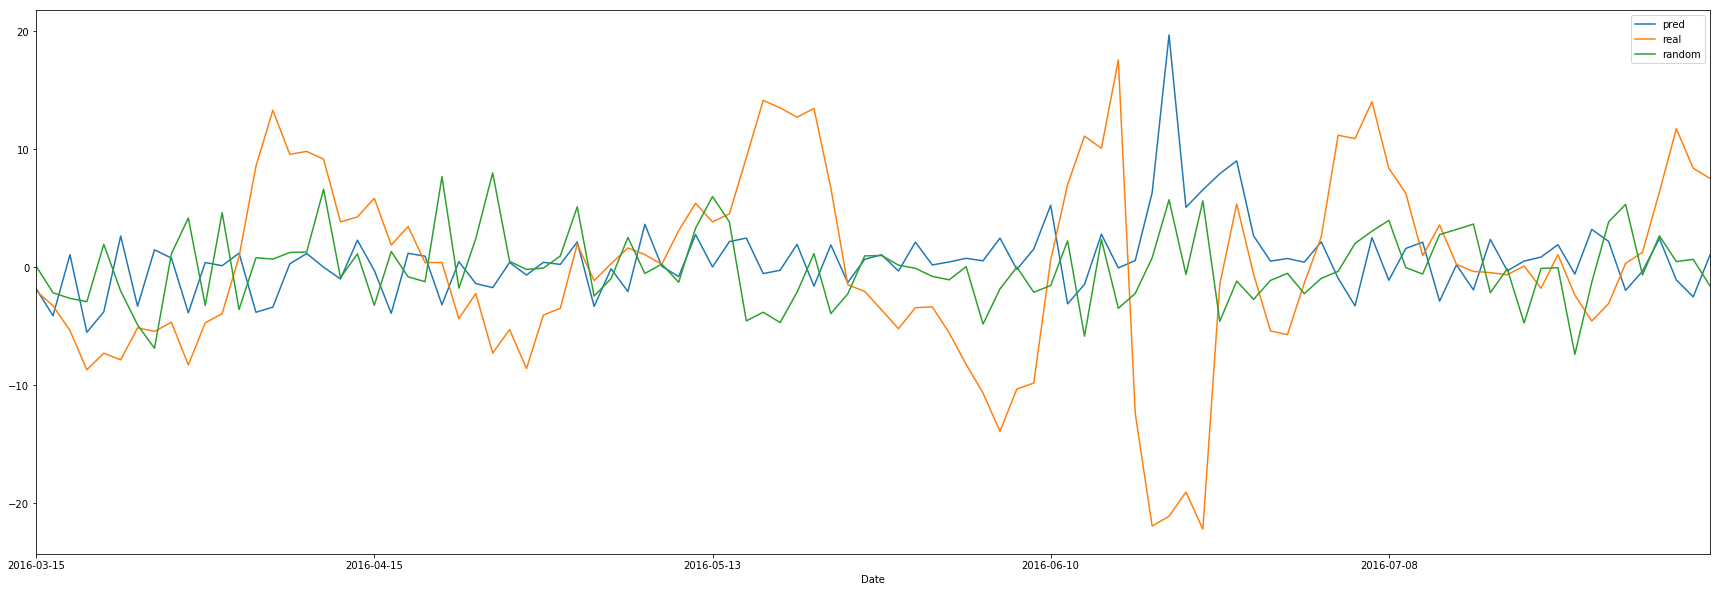

In [320]:
comparison['random'] = np.random.normal(loc=0,scale=3,size=comparison.shape[0])
comparison[:100].plot()
plt.show()

How many times do we get the direction right ?

In [327]:
direction = sum(comparison.iloc[:,0]*comparison.iloc[:,1]>0)/float(comparison.shape[0])
print str(int(direction*100)) + '% of the time we get the direction right'

46% of the time we get the direction right


How did we do on the training set ?

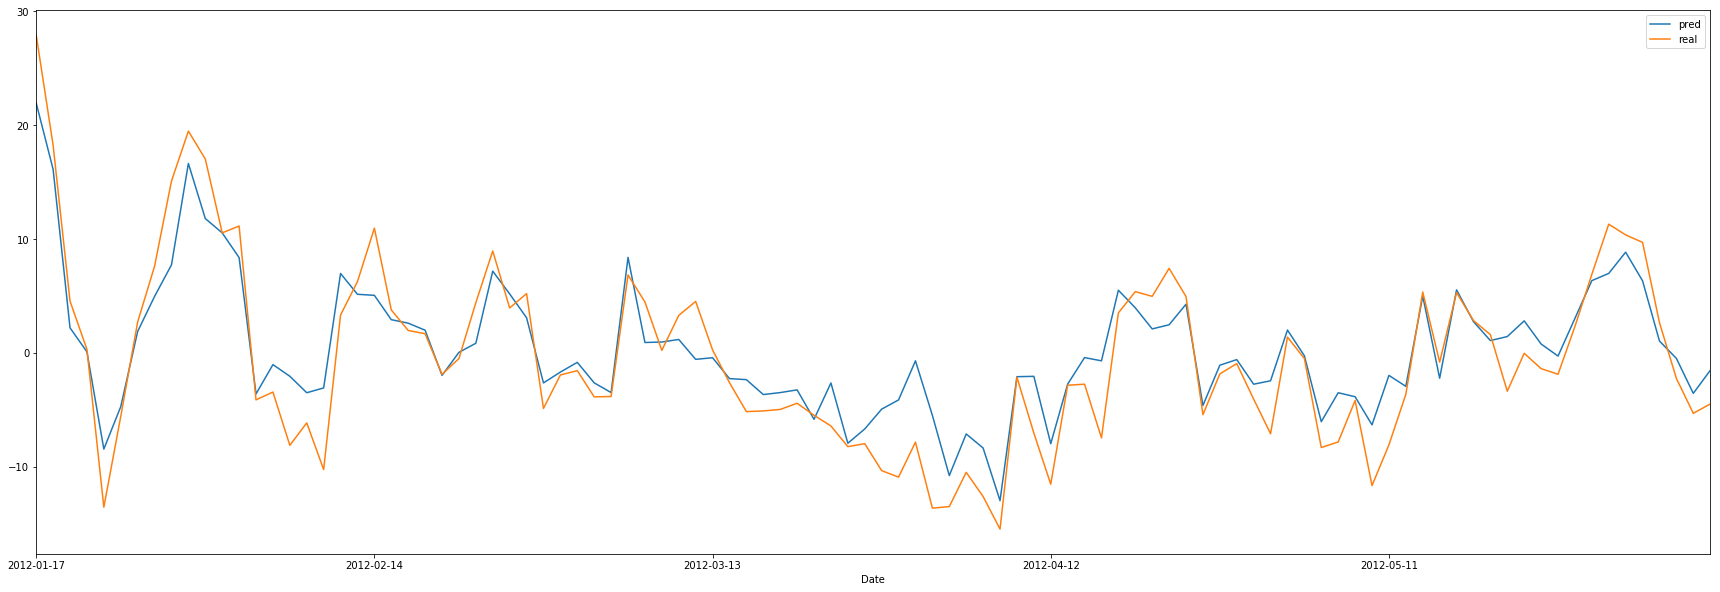

In [347]:
Y_pred_train = pd.Series(clf.predict(X_train))
Y_pred_train.index = Y_train.index
comparison_train = pd.concat([Y_pred_train,Y_train],axis=1)
comparison_train.columns = ['pred','real']
comparison_train[:100].plot()
plt.show()

# 4. LEARNING CURVE 

We use a learning curve to diagnose what went wrong.

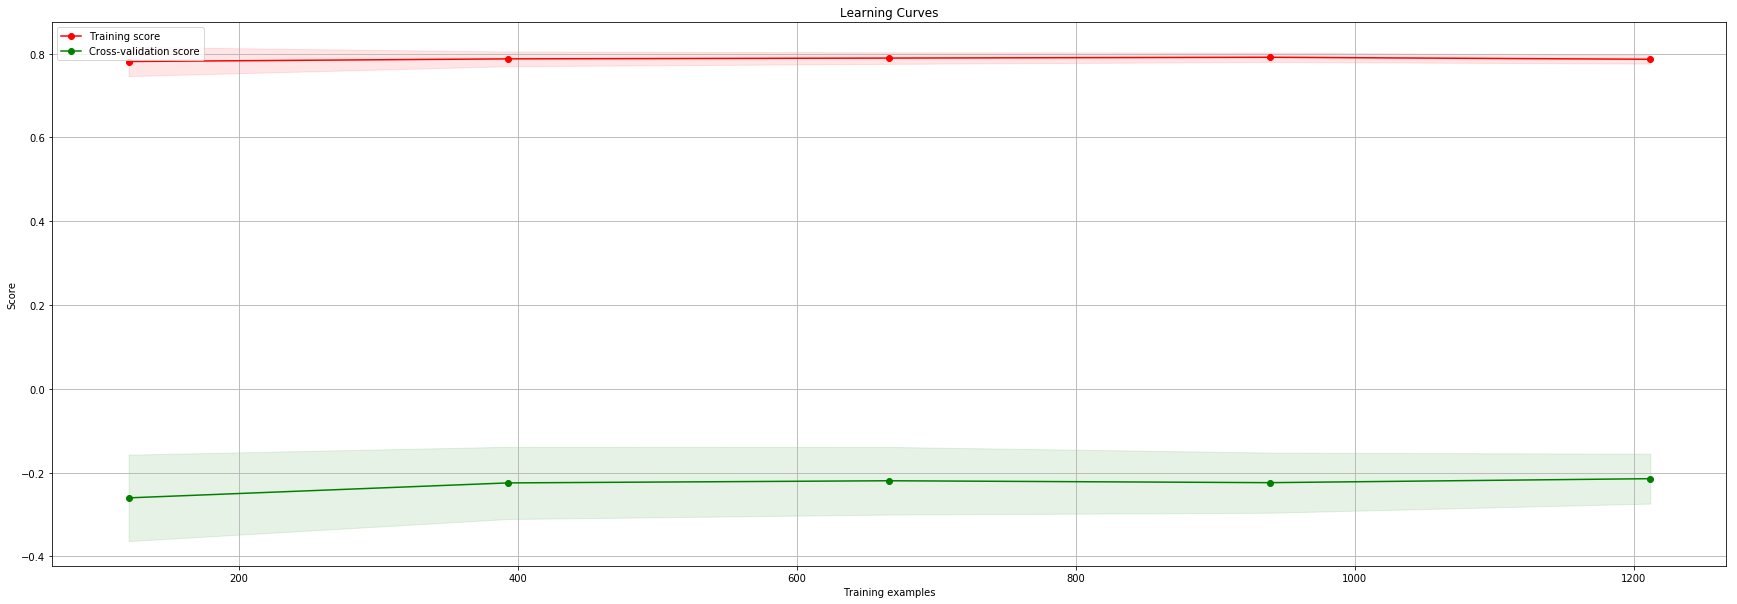

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

    
    return plt


title = "Learning Curves"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = clf
plot_learning_curve(estimator, title, X, Y, cv=cv, n_jobs=4)

plt.show()

From what we see we could improve the situation by adding more data ! <br>
1500 data points is not a lot...

# MORE DATA

In [352]:
def get_df(TICKER,window_size=10):
    ser = get_series(TICKER)
    print_info_stock(ser)
    ser = ser[ser.notnull()]
    df = pd.concat([ser,df_bollinger_features(ser,window_size),df_momentum(ser),y(ser)], axis=1)
    return df

nom      : AI.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 0


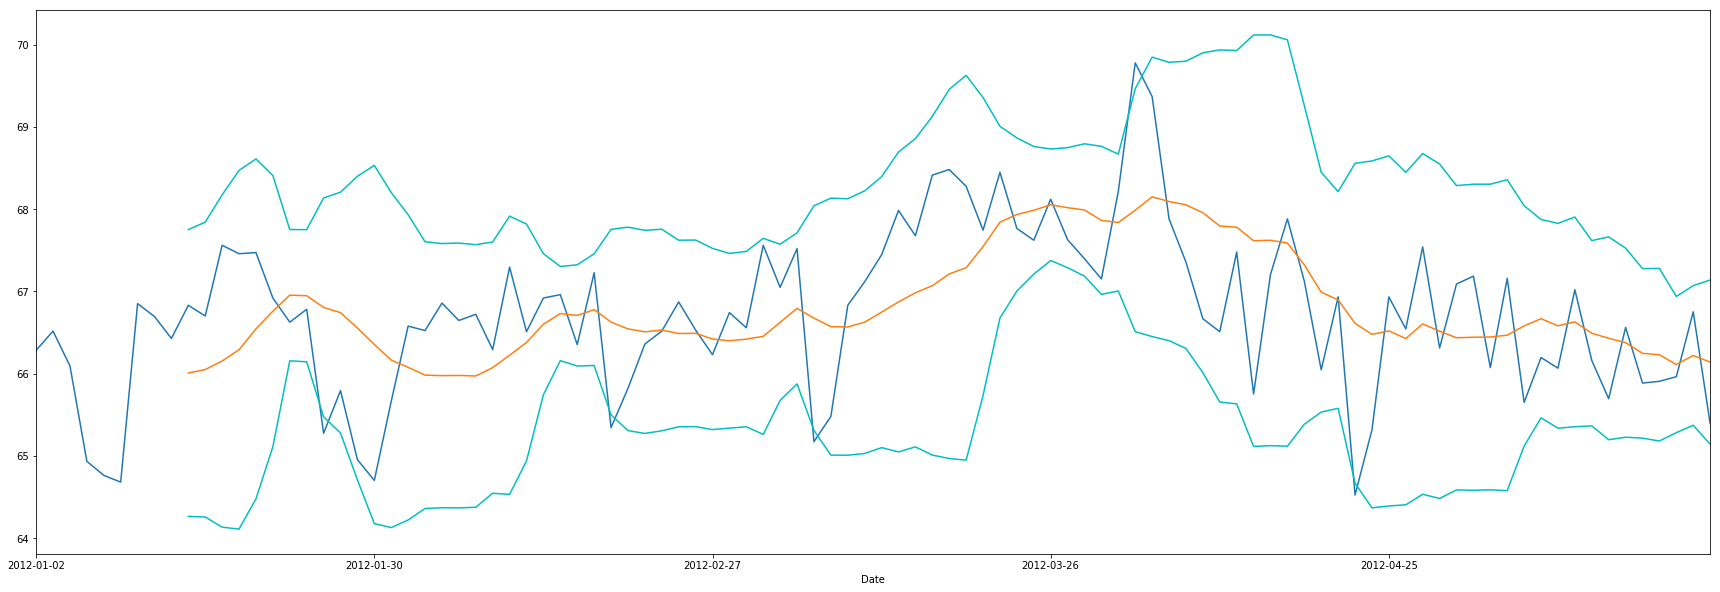

nom      : AIR.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 2


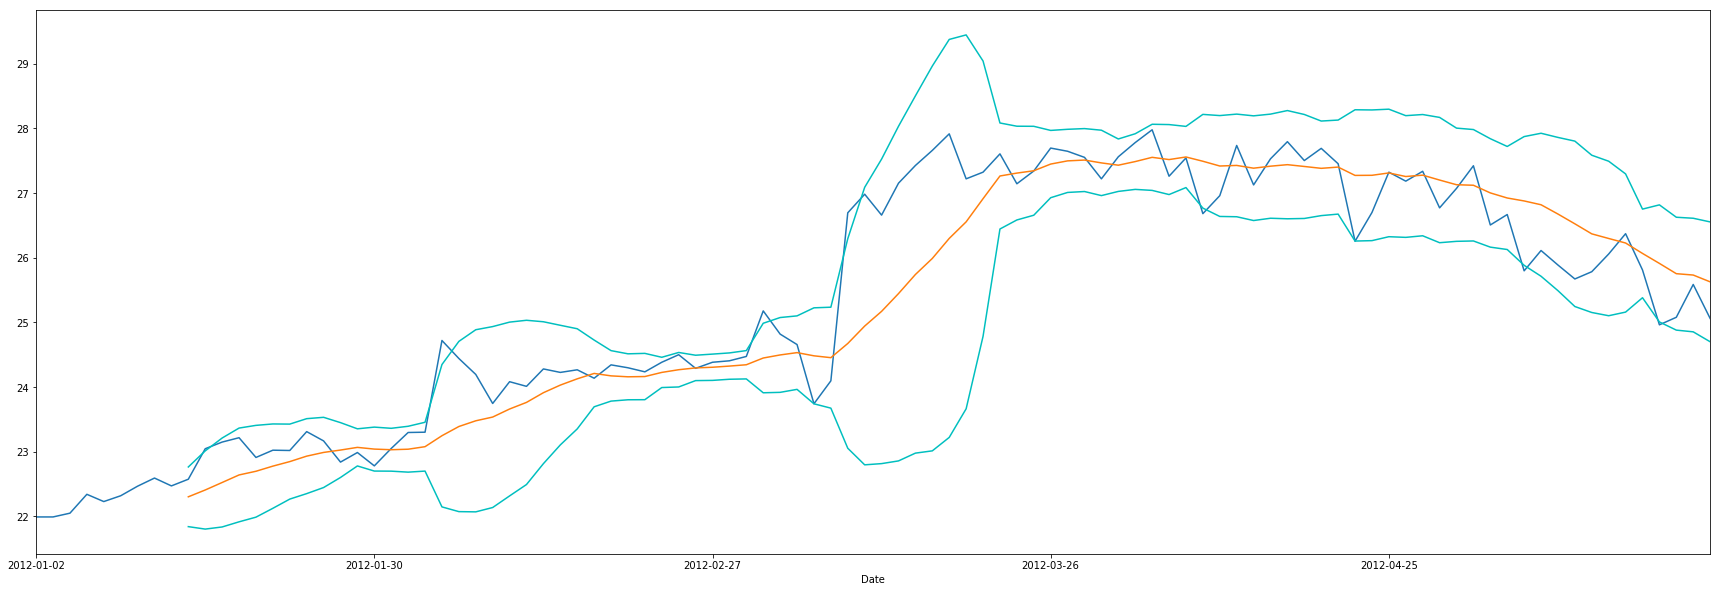

nom      : BN.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 0


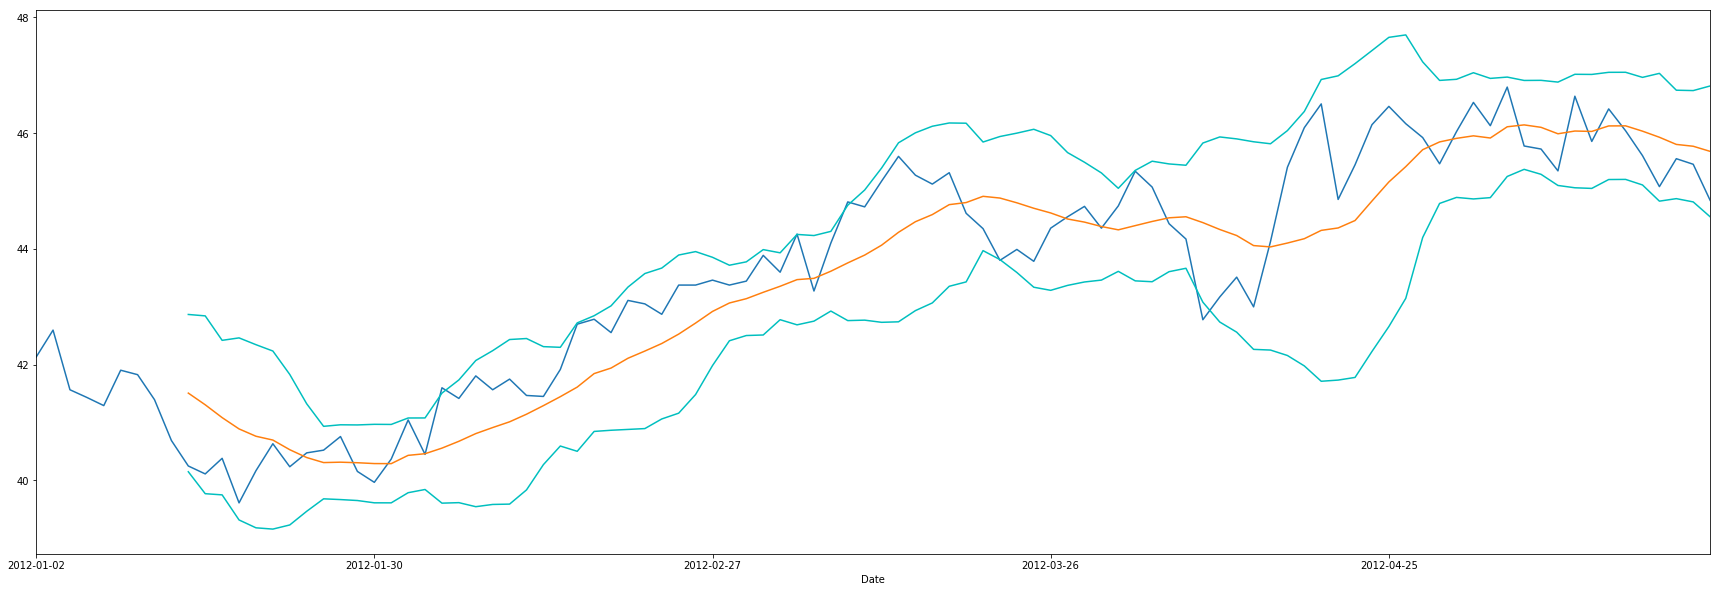

nom      : BNP.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


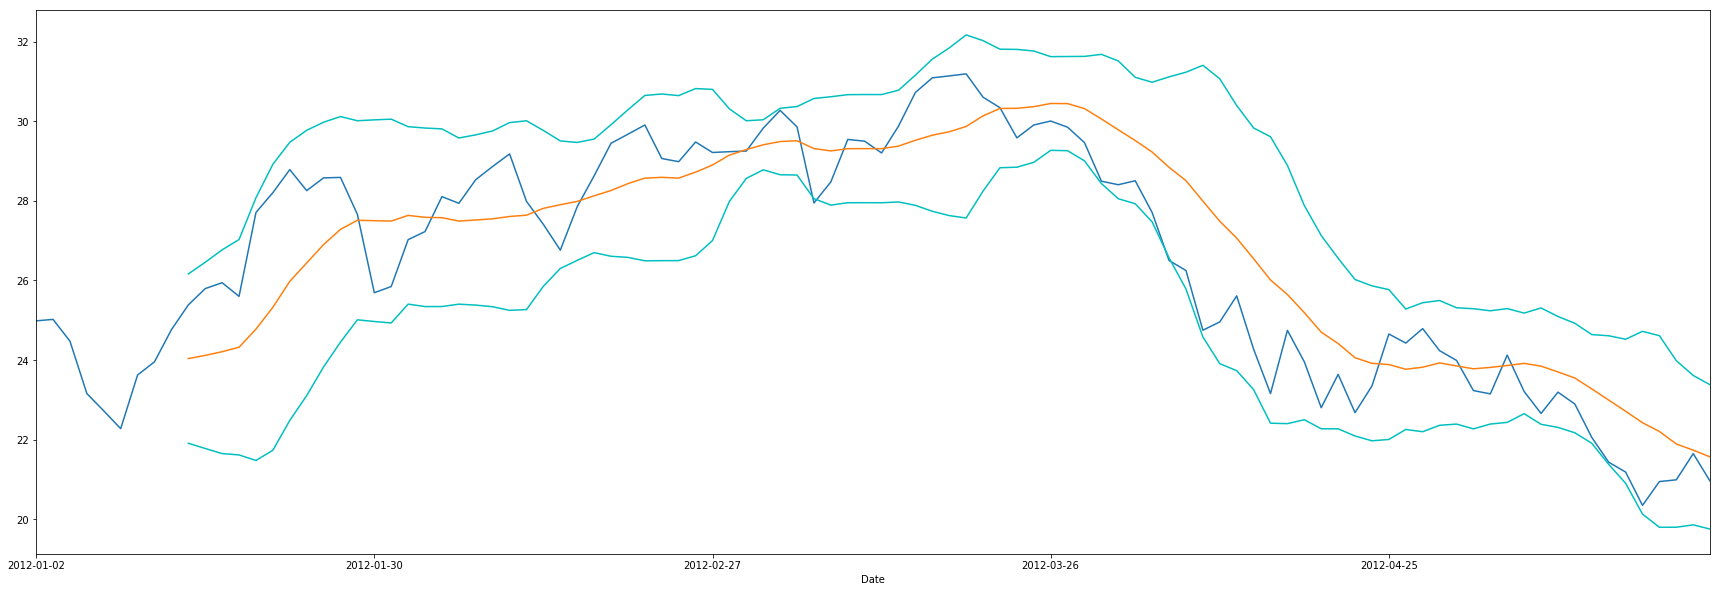

nom      : CS.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 0


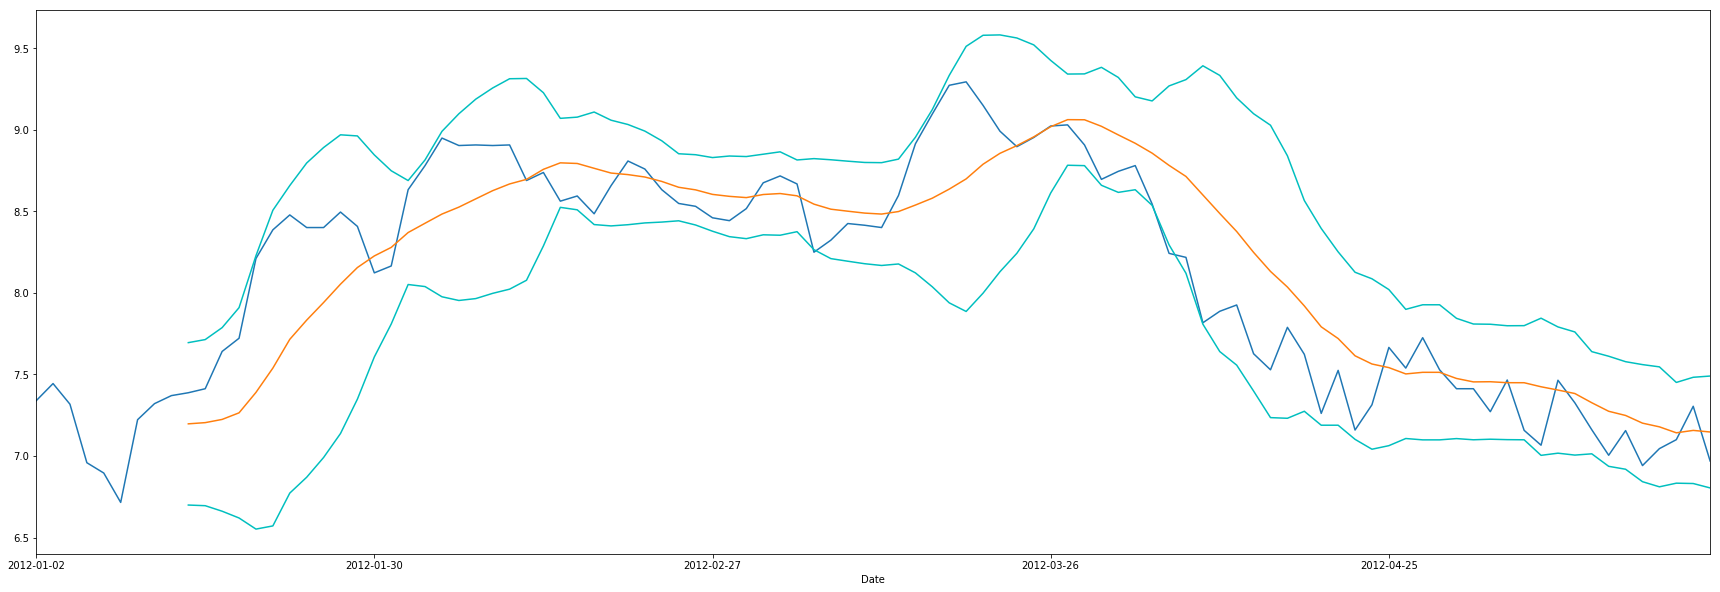

nom      : DG.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


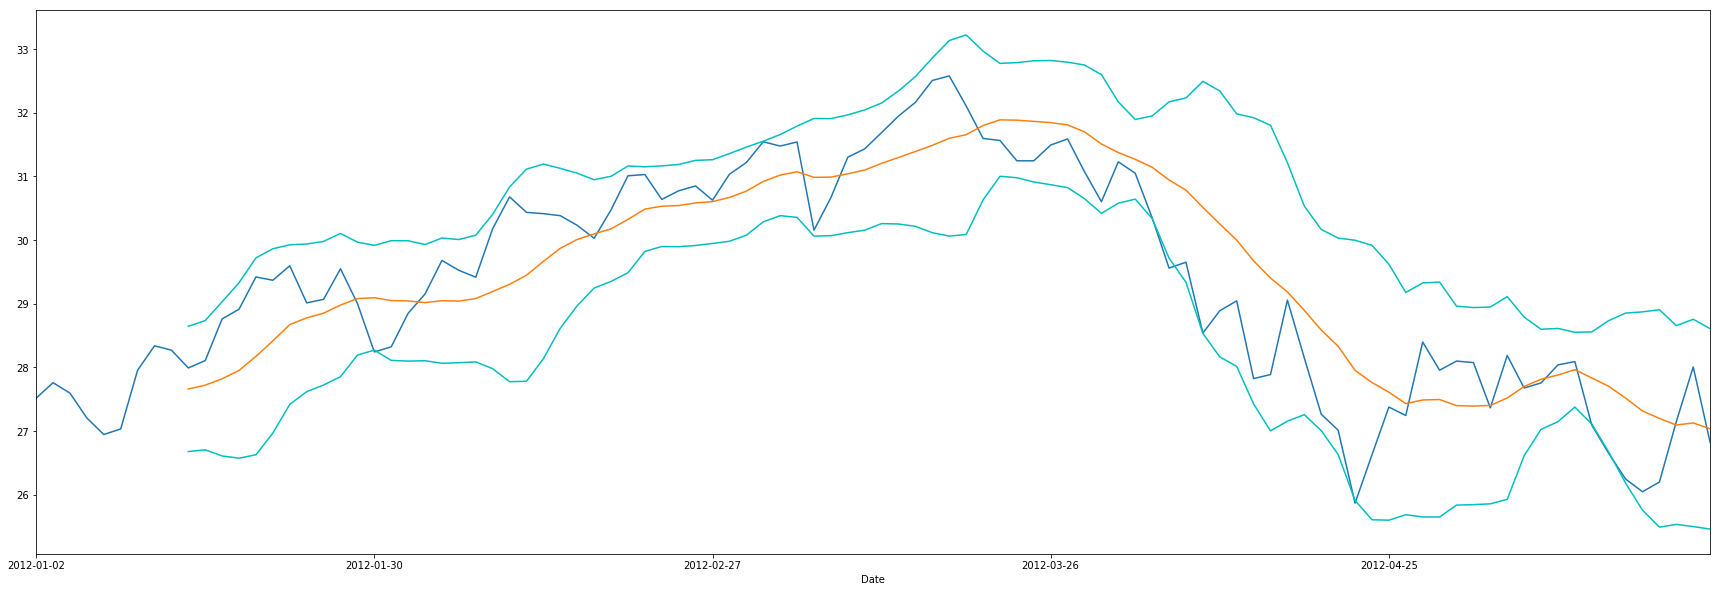

nom      : FP.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 0


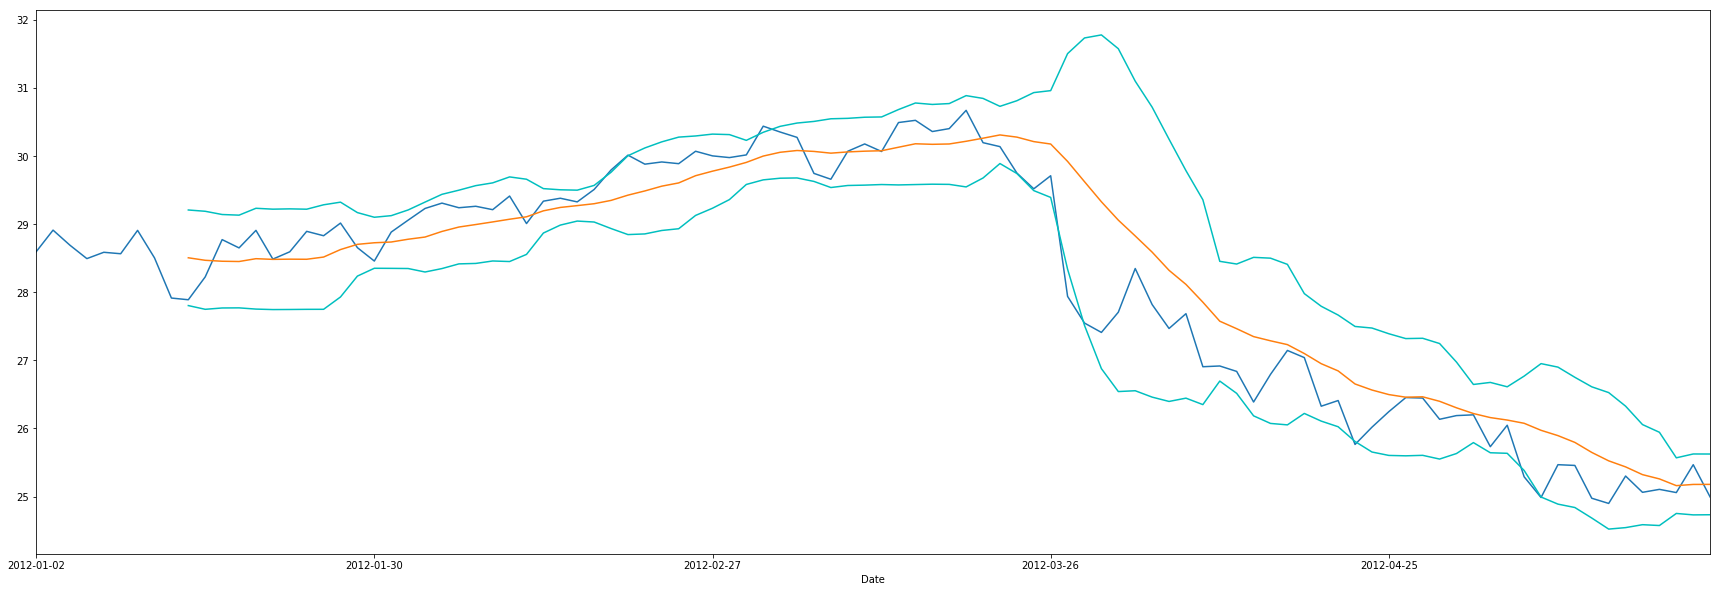

nom      : GLE.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


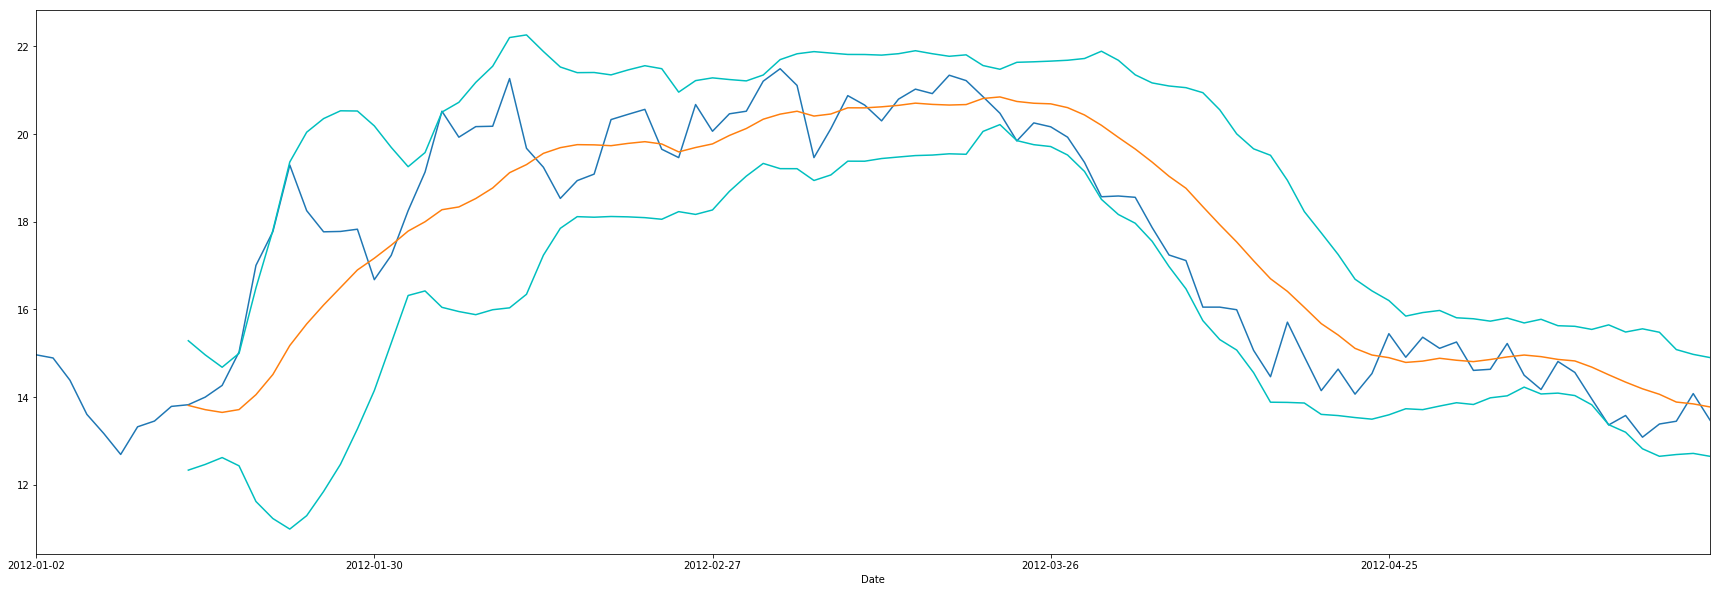

nom      : MC.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


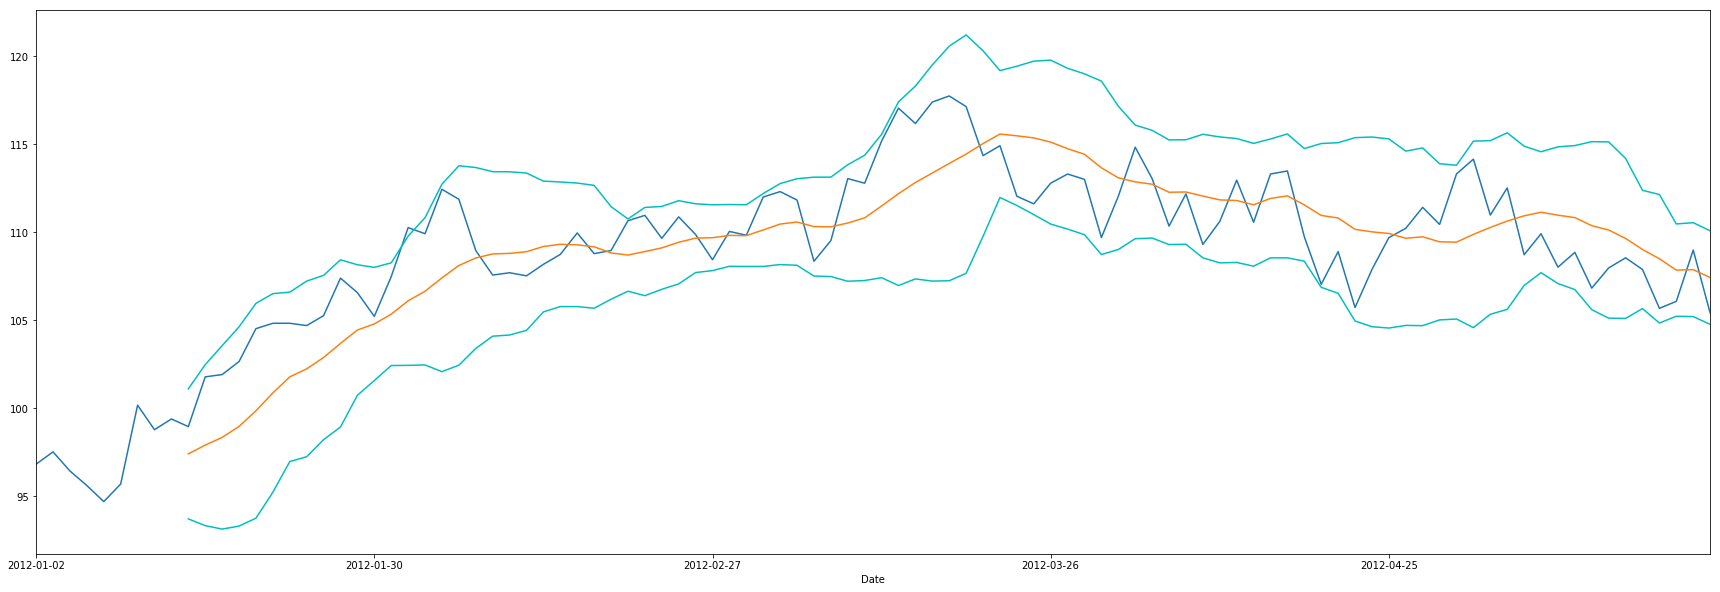

nom      : MT.AS.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1533
null     : 0


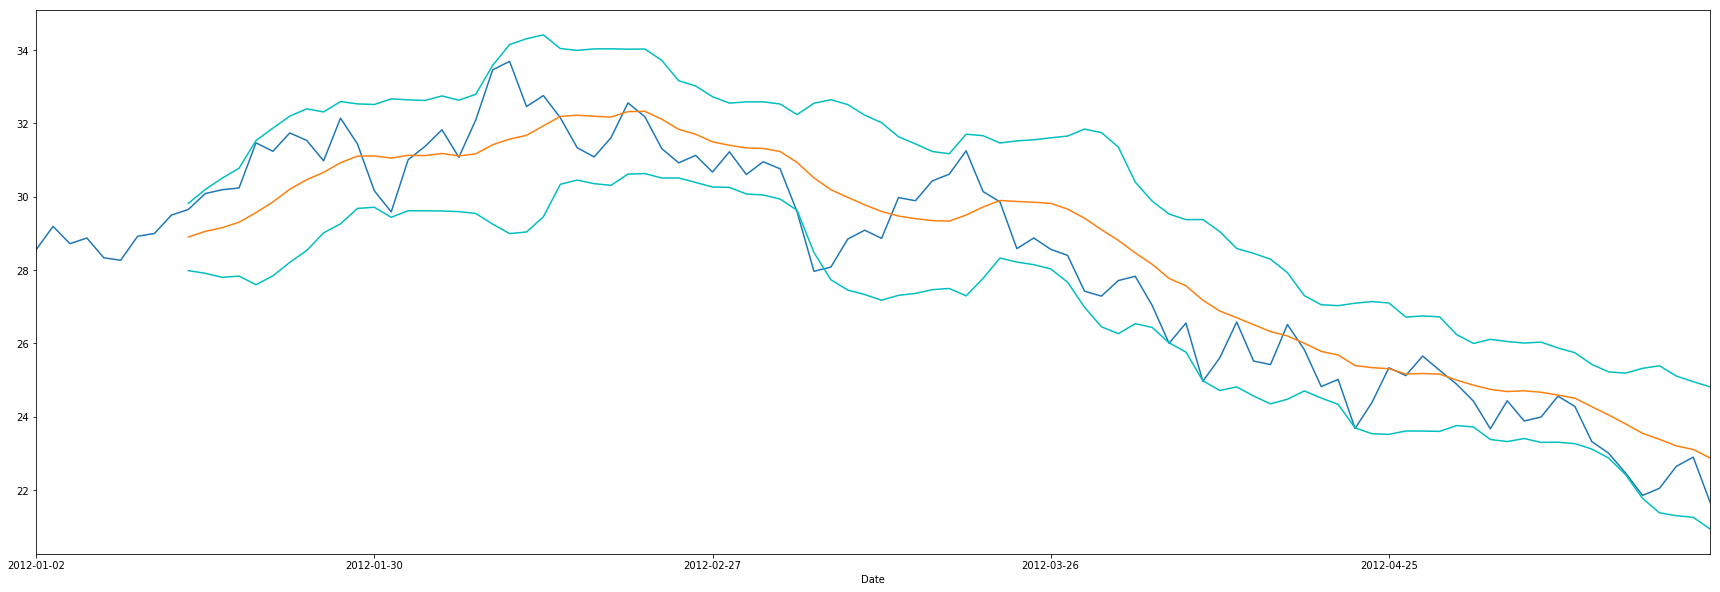

nom      : OR.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


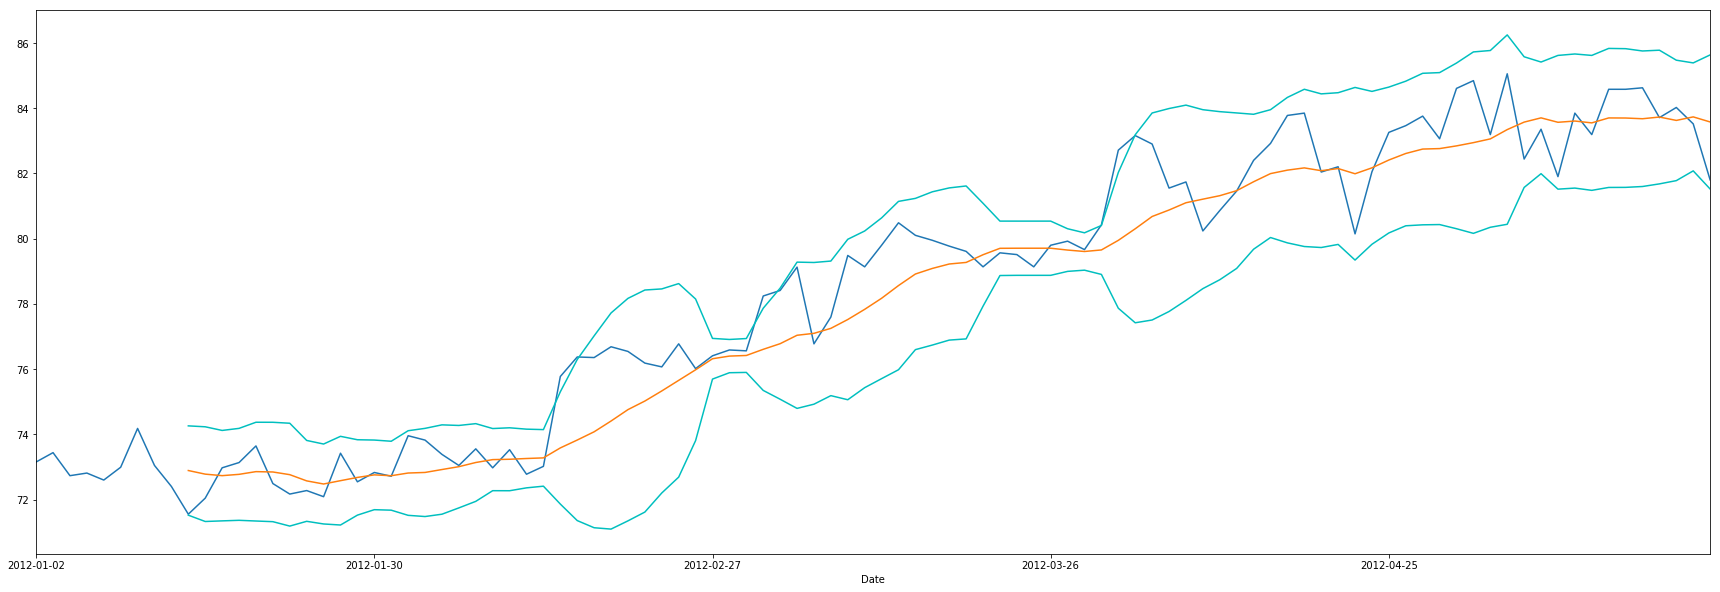

nom      : SAN.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


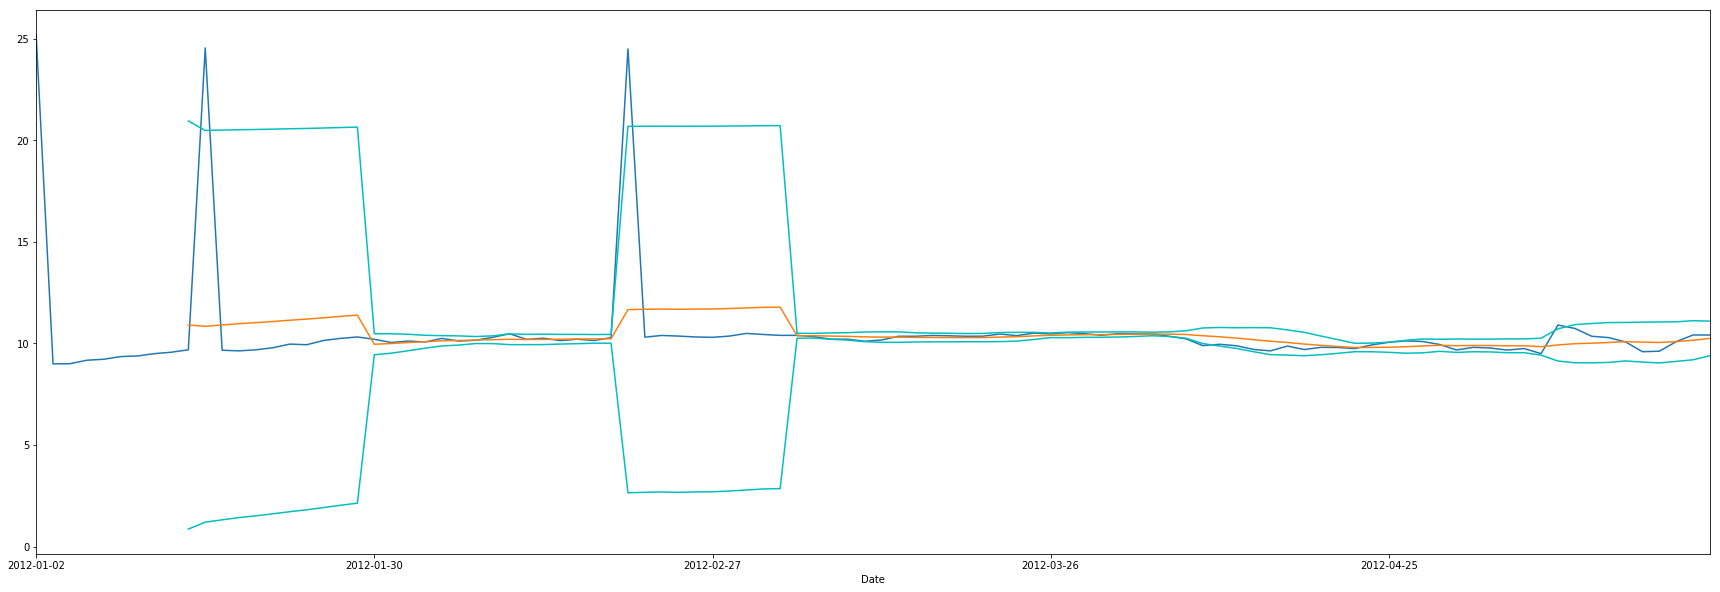

nom      : SU.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 0


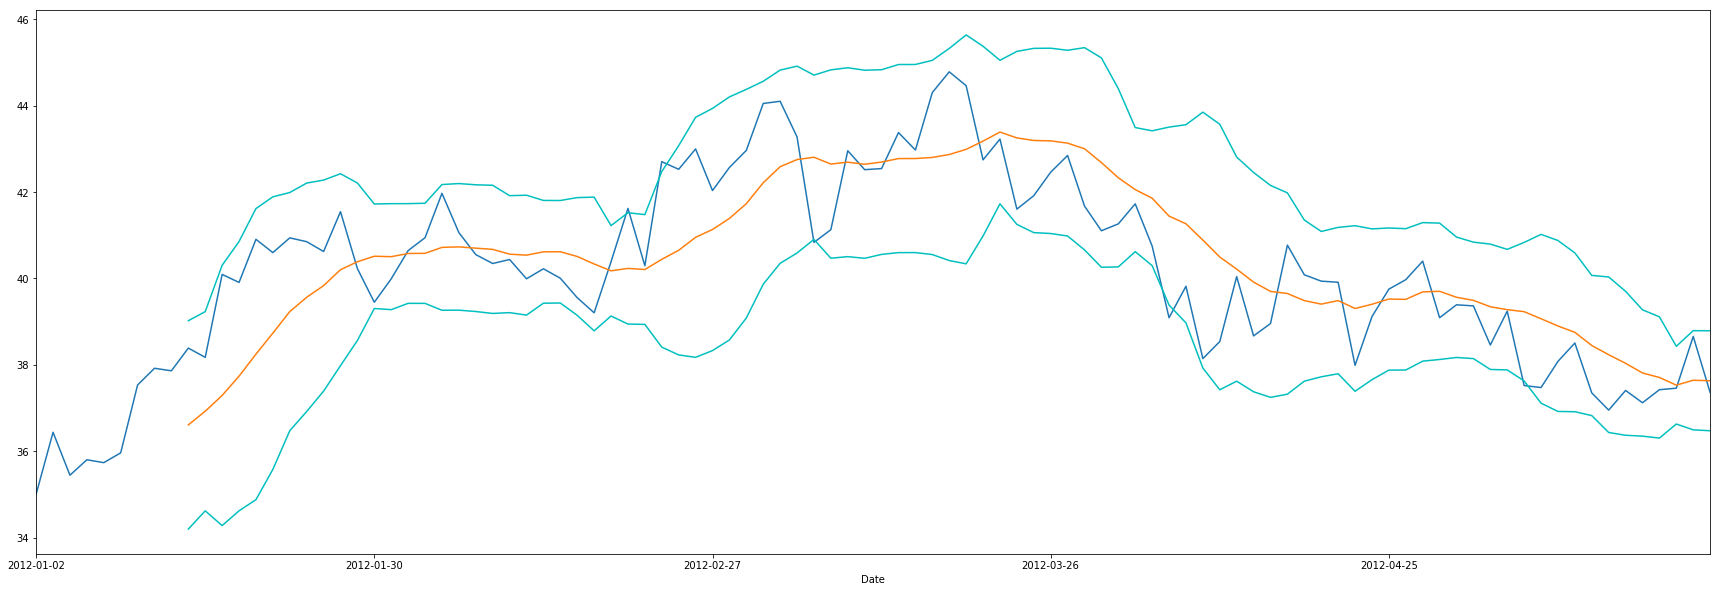

nom      : VIE.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 1


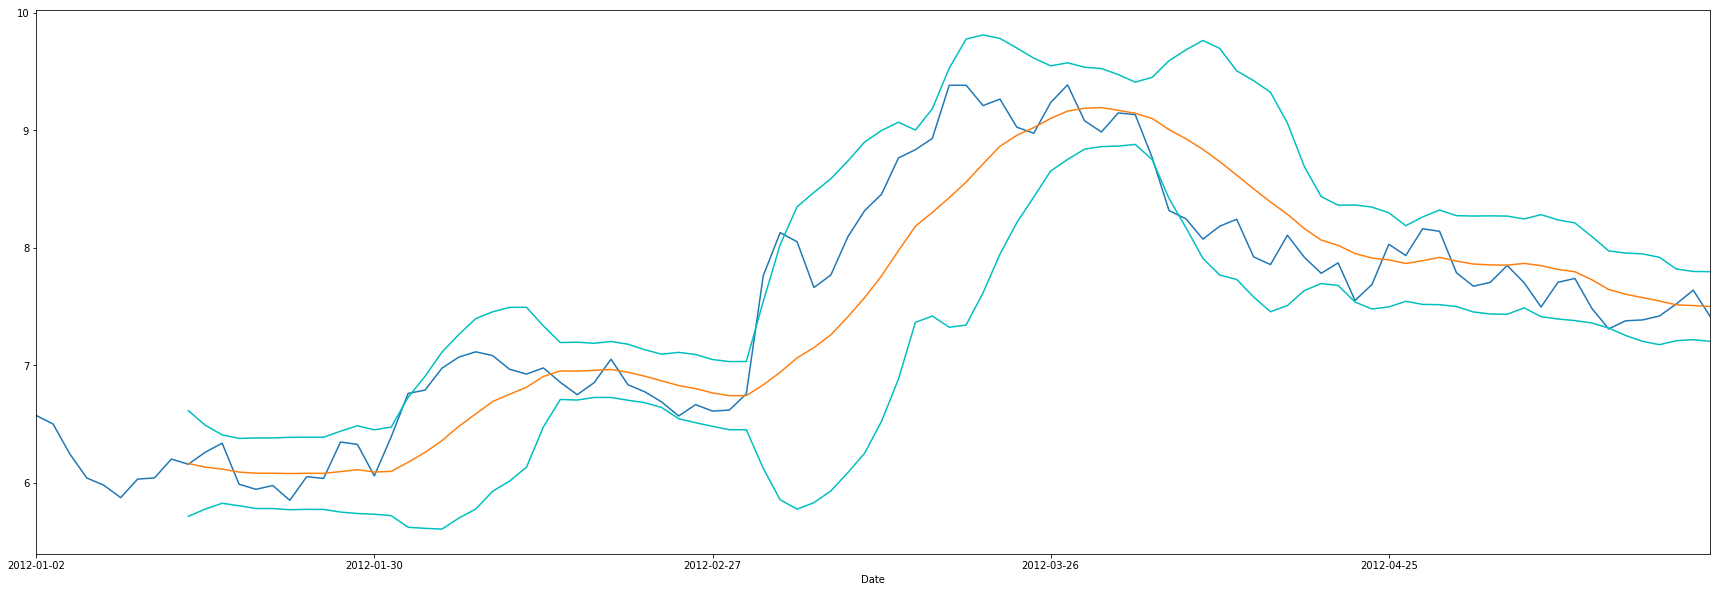

nom      : VIV.PA.csv
min date : 2012-01-02
max date : 2017-12-29
nb dates : 1532
null     : 2


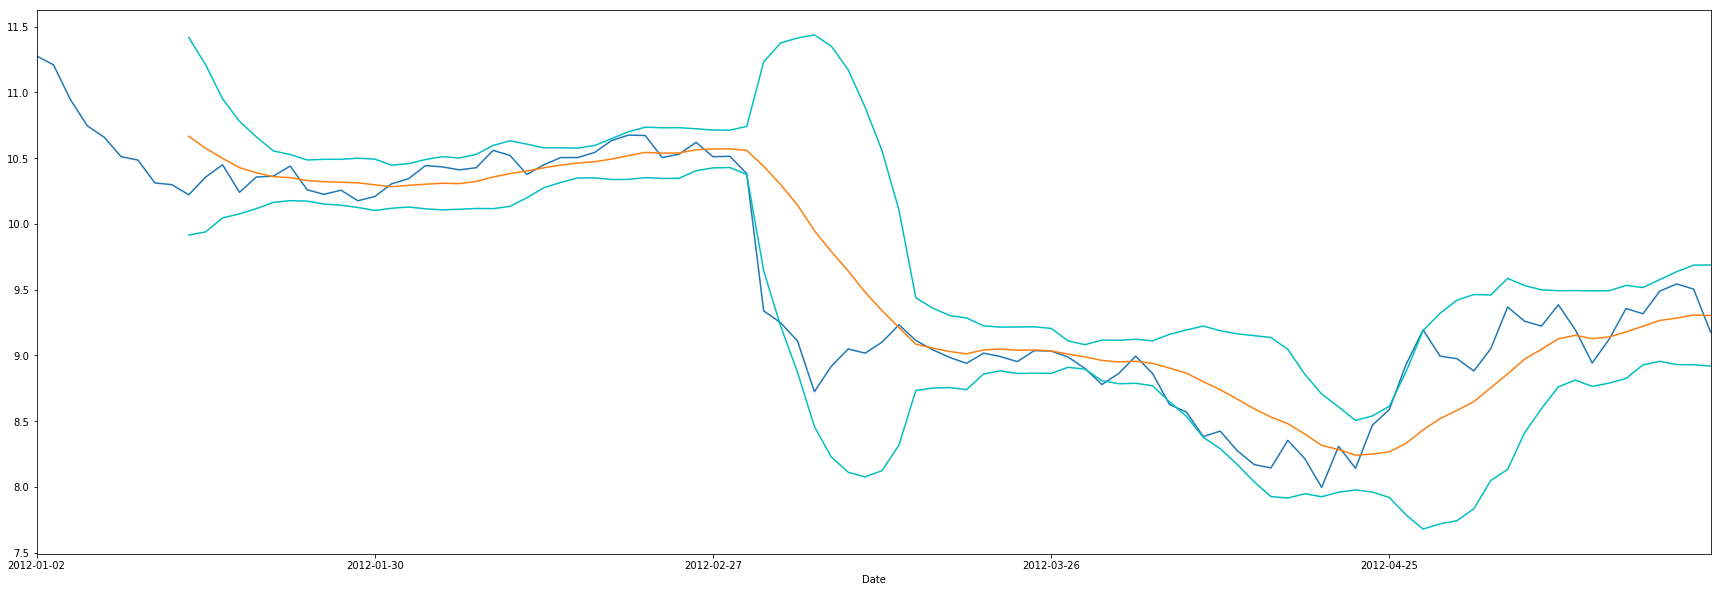

In [364]:
# i want the list of the files from there 
import os
tickers = os.listdir("/Users/edouardcuny/Desktop/quant/Carmela/data/")
l = []
for ticker in tickers:
    if 'csv' in ticker:
     l.append(get_df(ticker))   